# Federated Dataset with data heterogeneity : generate dataset with label distribution skewness

This notebook provides **additional material to the Practical Session 2**.  It showcases how to split datasets using Dirichlet allocation. 


We will focus on the MedNIST dataset, using the first 3 labels


Indeed, when using such approach when splitting dataset, we have to ensure that the number of nodes equals the number of classes used


In [2]:
# access the MedNIST dataset
import os
data_path = os.path.join(os.getcwd(), 'data', 'MedNIST')  # enter here the path on your device towards MedNIST dataset


In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np

from scipy.stats import dirichlet
# Create a custom pytorch dataset
preprocess = transforms.Compose([transforms.ToTensor(),
                                        ])
data = datasets.ImageFolder(data_path,transform = preprocess)



In [ ]:
random_seed = 1234
n_nodes = 3
n_classes = 3
n_data_per_class = 5000
n_samples = n_classes * n_data_per_class

index_arr = np.arange(n_samples )

alpha = 1000  # alpha for dirichlet 


In [8]:
# investigate the MedNIST dataset before proceeding

np.unique(data.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([10000,  8954, 10000, 10000, 10000, 10000]))

In [7]:
np.unique(train_targets, return_counts=True)

(array([0, 1, 2]), array([5000, 5000, 5000]))

## Sampling Dirichlet distribution
Dirichlet distribution has interesting properties that one can use to split dataset in a heterogenous way. Try to play with the alpha parameter in order to see how Dirichlet law behaves


One of the property of Dirichlet distribution is that
$\sum_{i=1}^k x_i = 1$, with $x_i$ samples from Dirichlet distribution, while $x_i>0$. 

Hence, each $x_i$ can be seen as a percentage of data for each label to sample


In [61]:

dirichlet.rvs([alpha]*n_nodes, n_classes)

array([[0.35066719, 0.38881275, 0.26052006],
       [0.38066558, 0.26387753, 0.35545689],
       [0.35021083, 0.29963504, 0.35015413]])

In [38]:
np.sum(dirichlet.rvs([alpha]*n_nodes, n_classes), axis=1)

array([1., 1., 1.])


## Split Dataset using Dirichlet distribution

In [10]:


def generate_train_targets(n_samples, n_data_per_class):
    """Creates targets list given number of samples and number of samples per class"""
    train_targets = []
    x = 0
    for i in range(n_samples):
        if i != 0 and i //n_data_per_class == x +1:
            x += 1
    
        train_targets.append(x)
    return train_targets

train_targets = generate_train_targets(n_samples, n_data_per_class)

In [93]:

import copy


def split_noniid(train_idcs, train_labels, alpha, n_clients, seed):
    '''
    Splits a list of data indices with corresponding labels
    into subsets according to a dirichlet distribution with parameter
    alpha
    '''
    np.random.seed(seed)
    n_classes = train_labels.max()+1
    label_distribution = dirichlet.rvs([alpha]*n_clients, n_classes)

    class_idcs = [np.argwhere(train_labels[train_idcs]==y).flatten() 
           for y in range(n_classes)]

    client_idcs = [[] for _ in range(n_clients)]
    for c, fracs in zip(class_idcs, label_distribution):
        cumsum = np.split(c, (np.cumsum(fracs)[:-1]*len(c)).astype(int))

        for i, idcs in enumerate(cumsum):
            client_idcs[i] += [idcs]
            #print(client_idcs)

    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]
    
    non_iid_label =copy.deepcopy(client_idcs)

    # create label from index
    for n in range(n_clients):
        
        for s in range(len(client_idcs[n])):
            non_iid_label[n][s] = train_labels[client_idcs[n][s]]
    return client_idcs, non_iid_label


In [97]:
non_iid_data, non_iid_label = split_noniid(index_arr, np.array(train_targets), alpha , n_nodes, random_seed)

In [98]:

# count how many label they are for each client
for n in range(3):
    print(np.unique(non_iid_label[n] ,return_counts=True))

(array([0, 1, 2]), array([ 603, 2282,  316]))
(array([0, 1, 2]), array([2762, 2245, 1582]))
(array([0, 1, 2]), array([1635,  473, 3102]))


## Dataset vizualisation for each Node

### Label distribution per Node

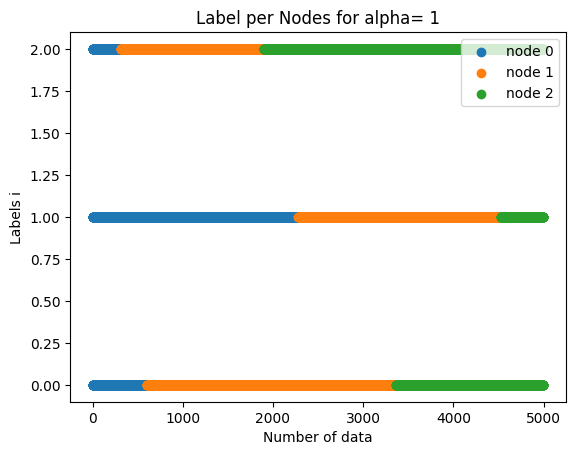

In [106]:

for i in range(3):
    plt.scatter(non_iid_data[i] - non_iid_label[i]*n_data_per_class ,  non_iid_label[i], label="node " + str(i))
    plt.xlabel("Number of data")
    plt.ylabel(f"Labels i")
    plt.legend()
    plt.title(f"Label per Nodes for alpha= {alpha}")


### Label count per Node

Text(0.5, 1.0, 'data label count per Nodes, for alpha = 1')

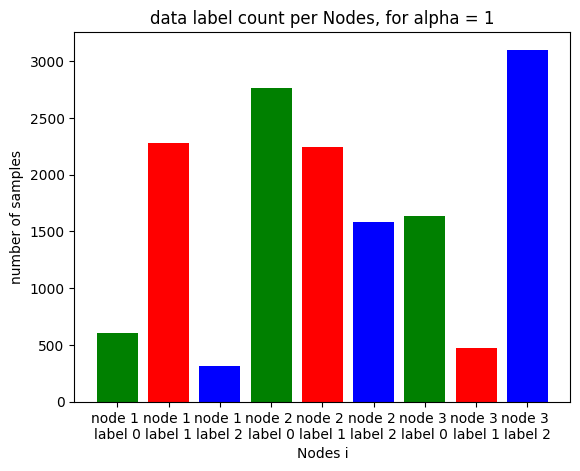

In [107]:
import matplotlib.pyplot as plt
color = ['g', 'r', 'b']

fig, ax = plt.subplots()
for i in range(3):
    for j in range(3):
        ax.bar( i*3+j, len(np.where(non_iid_label[i] ==j)[0]) , color=color[j])

        ax.set_xlabel(f"Nodes i")
        ax.set_ylabel("number of samples")
        #plt.legend()
ax.set_xticks(np.arange(9), labels=[f"node {i //3 +1} \nlabel {i%3}" for i in range(9) ])
plt.title(f"data label count per Nodes, for alpha = {alpha}")

In [19]:
print(.1)

0.1
